
# Prototipagem de Modelo Preditivo Temporal (Forecasting)
**Objetivo**: Antecipar o risco de defasagem escolar no ano seguinte (T+1) usando dados do ano atual (T).

**Estratégia Temporal**:
- **Dados de Treino**: Usar alunos de **2022** para prever o risco em **2023**.
- **Dados de Teste**: Usar alunos de **2023** para prever o risco em **2024**.
- **Métrica**: Avaliaremos se o modelo treinado no passado consegue generalizar para o futuro.

**Definição de Target**:
- **Risco em T+1**: O aluno terá defasagem < 0 no próximo ano?


In [1]:

import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.impute import SimpleImputer

pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
%matplotlib inline


In [2]:

file_path = '../BASE DE DADOS PEDE 2024 - DATATHON.xlsx'
if not os.path.exists(file_path):
    file_path = 'BASE DE DADOS PEDE 2024 - DATATHON.xlsx'

def load_data_by_year(file_path):
    xls = pd.ExcelFile(file_path)
    data = {}
    
    # --- 2022 ---
    if 'PEDE2022' in xls.sheet_names:
        df = pd.read_excel(xls, 'PEDE2022')
        # Padronizar
        df.rename(columns={
            'INDE 22': 'INDE', 'Defas': 'Defasagem', 'IAA': 'IAA', 'IEG': 'IEG', 'IPS': 'IPS', 'IDA': 'IDA', 'IPV': 'IPV', 'IAN': 'IAN'
        }, inplace=True)
        # Limpeza Numérica
        for col in ['IAA', 'IEG', 'IPS', 'IDA', 'IPV', 'IAN', 'INDE', 'Defasagem']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Garantir RA string
        df['RA'] = df['RA'].astype(str).str.strip()
        data[2022] = df
        
    # --- 2023 ---
    if 'PEDE2023' in xls.sheet_names:
        df = pd.read_excel(xls, 'PEDE2023')
        df.rename(columns={'INDE 2023': 'INDE'}, inplace=True)
         # Limpeza Numérica
        for col in ['IAA', 'IEG', 'IPS', 'IDA', 'IPV', 'IPP', 'IAN', 'INDE', 'Defasagem']:
             if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                
        df['RA'] = df['RA'].astype(str).str.strip()
        data[2023] = df

    # --- 2024 ---
    if 'PEDE2024' in xls.sheet_names:
        df = pd.read_excel(xls, 'PEDE2024')
        df.rename(columns={'INDE 2024': 'INDE'}, inplace=True)
         # Limpeza Numérica
        for col in ['IAA', 'IEG', 'IPS', 'IDA', 'IPV', 'IPP', 'IAN', 'INDE', 'Defasagem']:
             if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                
        df['RA'] = df['RA'].astype(str).str.strip()
        data[2024] = df
        
    return data

data_dict = load_data_by_year(file_path)
print("Anos carregados:", data_dict.keys())


Anos carregados: dict_keys([2022, 2023, 2024])


In [3]:

def create_temporal_dataset(df_t, df_next, year_t):
    # Selecionar Features de T (Indicadores + Demográficos)
    # Target vem de T+1
    
    # Features de interesse em T
    features_t = ['RA', 'Fase', 'IAA', 'IEG', 'IPS', 'IDA', 'IPP', 'IPV', 'IAN', 'INDE', 'Defasagem']
    features_t = [f for f in features_t if f in df_t.columns]
    
    X = df_t[features_t].copy()
    
    # Target em T+1: Defasagem
    # Queremos prever o STATUS futuro.
    # Join por RA
    if 'Defasagem' in df_next.columns:
        Y = df_next[['RA', 'Defasagem']].copy()
        Y.rename(columns={'Defasagem': 'Defasagem_Next'}, inplace=True)
        
        # Merge
        df_merged = pd.merge(X, Y, on='RA', how='inner')
        
        # Criar Target Binário: Risco Futuro (Defasagem_Next < 0)
        df_merged['Target_Risk_Next'] = (df_merged['Defasagem_Next'] < 0).astype(int)
        df_merged['Year_T'] = year_t
        
        return df_merged
    else:
        print(f"Defasagem não encontrada no ano seguinte ao {year_t}")
        return pd.DataFrame()

# Criar Dataset de Treino (2022 -> 2023)
train_df = create_temporal_dataset(data_dict[2022], data_dict[2023], 2022)
print(f"Dataset Treino (2022->2023): {train_df.shape if not train_df.empty else 'Vazio'}")

# Criar Dataset de Teste (2023 -> 2024)
test_df = create_temporal_dataset(data_dict[2023], data_dict[2024], 2023)
print(f"Dataset Teste (2023->2024): {test_df.shape if not test_df.empty else 'Vazio'}")


Dataset Treino (2022->2023): (600, 13)
Dataset Teste (2023->2024): (765, 14)


In [4]:

# Features para modelagem (Remover metadados e Targets)
remove_cols = ['RA', 'Defasagem_Next', 'Target_Risk_Next', 'Year_T', 'Fase'] # Fase pode ser categórica, por simplificação vamos remover ou tratar
# Vamos manter apenas indicadores numéricos por enquanto para simplificar o baseline
feature_cols = ['IAA', 'IEG', 'IPS', 'IDA', 'IPP', 'IPV', 'IAN', 'INDE', 'Defasagem'] # Defasagem atual é feature!

# Garantir que todas as colunas existem
feature_cols = [c for c in feature_cols if c in train_df.columns and c in test_df.columns]

X_train = train_df[feature_cols]
y_train = train_df['Target_Risk_Next']

X_test = test_df[feature_cols]
y_test = test_df['Target_Risk_Next']

# Imputação (IPP pode faltar em 2022)
imputer = SimpleImputer(strategy='median')
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

print("Features finais:", feature_cols)


Features finais: ['IAA', 'IEG', 'IPS', 'IDA', 'IPV', 'IAN', 'INDE', 'Defasagem']


--- Validação Temporal (Treino: 22->23, Teste: 23->24) ---
              precision    recall  f1-score   support

           0       0.74      0.84      0.79       457
           1       0.70      0.56      0.63       308

    accuracy                           0.73       765
   macro avg       0.72      0.70      0.71       765
weighted avg       0.73      0.73      0.72       765

ROC AUC: 0.7676


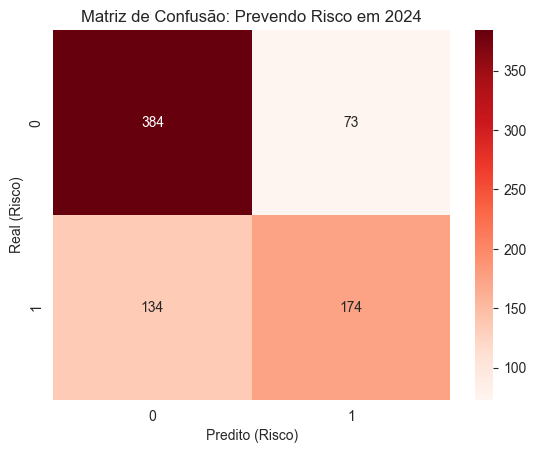

In [5]:

# Modelo Temporal
clf = RandomForestClassifier(n_estimators=200, max_depth=5, class_weight='balanced', random_state=42)
clf.fit(X_train_imp, y_train)

# Predições no Futuro (2024)
y_pred = clf.predict(X_test_imp)
y_prob = clf.predict_proba(X_test_imp)[:, 1]

print("--- Validação Temporal (Treino: 22->23, Teste: 23->24) ---")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("Matriz de Confusão: Prevendo Risco em 2024")
plt.xlabel("Predito (Risco)")
plt.ylabel("Real (Risco)")
plt.show()


C:\Users\manoe\AppData\Local\Temp\ipykernel_15524\898393315.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=imp, palette='magma')


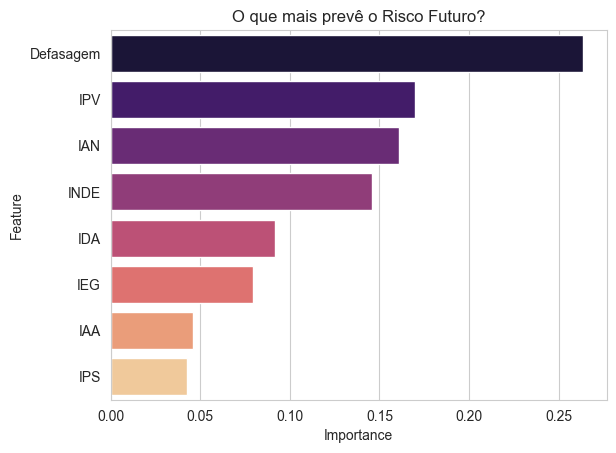

Este modelo nos diz quais indicadores HOJE são sinais de alerta para o AMANHÃ.


In [6]:

imp = pd.DataFrame({'Feature': feature_cols, 'Importance': clf.feature_importances_}).sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=imp, palette='magma')
plt.title("O que mais prevê o Risco Futuro?")
plt.show()

print("Este modelo nos diz quais indicadores HOJE são sinais de alerta para o AMANHÃ.")
